# Single Agent Snek
In this notebook, we want to analyze the performances, critical features and results for the single agent environment.

## Draft roadmap
- Loading and rendering of the environment on notebook (save on GIF)
- Optimal solution performance and rendering
- DQN experiments
    - Network size
    - Learnt model visual reconstruction
- ...

## Visualizing the environment

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image
from IPython import display
import gym, sneks
import numpy as np
import sys

rc('animation', html='html5')

In [2]:
env = gym.make('snek-rgb-16-v1')

In [3]:
def play_one_episode(env, policy):
    obs = env.reset()
    observations, done, steps, reward = [obs], False, 0, 0
    while not done:
        obs, r, done, _ = env.step(policy(obs))
        reward += r
        steps += 1
        observations.append(obs)
    return observations, steps, reward

In [4]:
observations, steps, reward = play_one_episode(env, lambda x: env.action_space.sample())
print("Episode return:", reward)
print("Episode length:", steps)

Episode return: -1
Episode length: 7


In [78]:
def saveualize(observations, filepath, figsize=(6,6)):
    fig, ax = plt.subplots(1, figsize=figsize)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    img = ax.imshow(observations[0])

    def animate(i):
        img.set_data(observations[i])
        return img

    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    anim = animation.FuncAnimation(fig, animate, frames=len(observations), interval=1000);
    anim.save(filepath, writer='imagemagick', fps=15)
    return Image(url=filepath, format='gif')

In [5]:
display.display(saveualize(observations, 'gifs/test_env.gif'))

## Simple policy

In [6]:
sys.path.append('..')
from benchmark.base_policy import HighlanderPolicy

In [7]:
pi = HighlanderPolicy(env)
observations, steps, reward = play_one_episode(env, lambda x: pi.act(x))
print("Episode return:", reward)
print("Episode length:", steps)

Episode return: 0
Episode length: 368


In [8]:
display.display(saveualize(observations, 'gifs/basic_policy.gif'))

## DQN policy - Small architecture
- CONV: (64, 4, 1)
- LINEAR: 256
- 1e7 timesteps
- 1e5 experience replay capacity
- 1e4 init timesteps
- epsilon from 1.0 to 0.02 on 1e5 timesteps
- update target net each 1000 timesteps
- batch size 32

In [9]:
# Create env for pytorch
from common.atari_wrappers import ScaledFloatFrame
from common.pytorch_utils import ImageToPyTorch
def make_env(env_name, rnd_seed):
    env = gym.make(env_name)
    env = ScaledFloatFrame(env)
    env = ImageToPyTorch(env)
    env.seed(rnd_seed)
    return env

env = make_env('snek-rgb-16-v1', 42)

In [40]:
# Create Qnetwork
import torch
from dqn.qnetwork import QNetwork

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = torch.load('../dqn/checkpoints/smally_base_10M.pth', map_location="cuda" if torch.cuda.is_available() else "cpu")
net = QNetwork(env.observation_space, env.action_space, arch=state['arch'], dueling=state.get('dueling', False)).to(device)
net.load_state_dict(state['state_dict'])

def q_act(obs):
    action = net(torch.from_numpy(np.expand_dims(obs, 0)).to(device)).argmax(dim=1)[0]
    return action

In [42]:
observations, steps, reward = play_one_episode(env, q_act)
print("Episode return:", reward)
print("Episode length:", steps)

Episode return: 32
Episode length: 586


In [43]:
# Reshape observations for matplotlib
observations = [np.transpose(obs, (1, 2, 0)) for obs in observations]

In [44]:
display.display(saveualize(observations, 'gifs/qsmall.gif'))

## Training logs

In [14]:
from common.sacred_utils import load_runs, filter_runs

In [17]:
dqn_runs = load_runs('../../sacred_data/sneks')
print('Loaded runs:', len(dqn_runs.keys()))

Loaded runs: 1


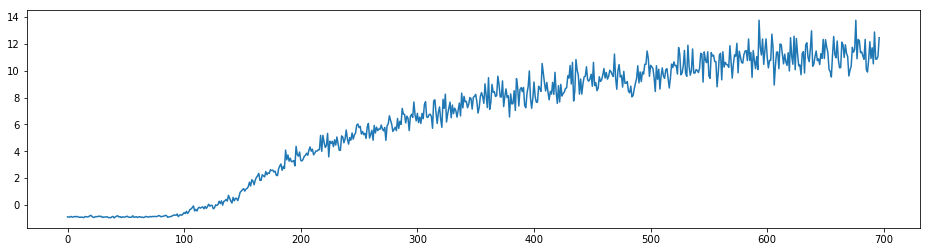

In [30]:
returns = dqn_runs[1]['metrics']['performance/return']['values']
# Rolling mean
returns = [np.mean(returns[i:i+100]) for i in range(0, len(returns), 100)]
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(returns)
plt.show();

In [28]:
print( dqn_runs[1]['metrics'].keys())

dict_keys(['internals/epsilon', 'internals/loss', 'internals/lr', 'performance/length', 'performance/return', 'performance/speed'])


TODO: histogram of performance in test

## Visualization of the network perception
We now want to understand what the agent is seeing. To do this, we fix the weights of the network (removing the last layer) and we create an auto-encoder, training it on observations from the environment. We then reconstruct each observation and compare it with the original one.

In [87]:
from perception.dqn_decoder import DqnDecoder

dqn_decoder = DqnDecoder(net).to(device)
dqn_decoder.load_state_dict(torch.load('../dqn/checkpoints/smally_base_10M_decoder_base4.pth', map_location="cuda" if torch.cuda.is_available() else "cpu"))

observations, steps, reward = play_one_episode(env, q_act)
observations = np.array(observations)
print("Episode return:", reward)
print("Episode length:", steps)

reconstruction = dqn_decoder(torch.from_numpy(observations).to(device), net).detach().numpy()
reconstruction = np.transpose(reconstruction, (0, 2, 3, 1))
observations = np.transpose(observations, (0, 2, 3, 1))
# Set observations and reconstructions side by side
composition = np.concatenate([observations, reconstruction], axis=2)

Episode return: 30
Episode length: 569


In [88]:
display.display(saveualize(composition, 'gifs/reconstruction.gif', figsize=(12, 6)))

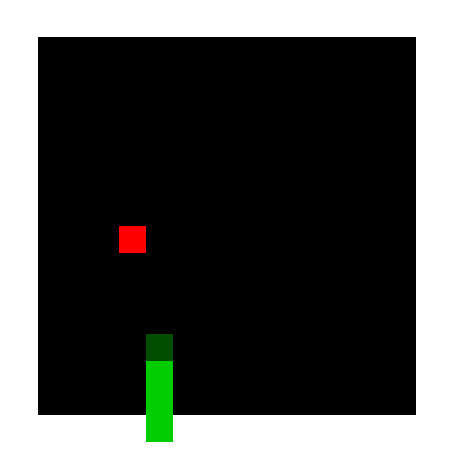

In [49]:
plt.imshow(observations[0])
plt.show();